In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import PIL
import read_datasets as rd
import constants as CONST
from importlib import reload
reload(rd)
reload(CONST)
import base64
import pickle
import collections
import itertools, collections
from sklearn.metrics import mean_squared_error
import cv2 

In [2]:
np.set_printoptions(precision=4, suppress=True)

In [ ]:
from tqdm import tqdm
drawing_arr = CONST.face_json['train_data']
n = 200
M_arr = collections.defaultdict(lambda : np.zeros(9))
M_name = collections.defaultdict(lambda : " ")

for idx in tqdm(range(len(drawing_arr))):
    strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
        drawing_arr[idx], 
        b_spline_num_sampled_points=200,
    )
    
    for stroke_index, data in enumerate(strokes_spline_fitted):
    
        min_template_name, min_template_mse = None, np.inf
        min_M = None
        for template_name, template_func in rd.TEMPLATE_DICT.items():
            template = template_func(n)
            try:
                M, result = rd.get_transform(template, data, projective=True)
                mse = rd.mean_squared_error(result, data)
                if mse < min_template_mse:
                    min_template_name = template_name
                    min_template_mse = mse
                    min_M = M
            except:
                continue
                print("Fail: ", template_name, " at: ", idx, stroke_index)
        
        if min_M is None:
            M_arr[(idx, stroke_index)] = np.zeros(9)
            M_name[(idx, stroke_index)] = 'line'
        else:
            M_arr[(idx, stroke_index)] = min_M.reshape(-1,)
            M_name[(idx, stroke_index)] = min_template_name

        
with open('/raid/xiaoyuz1/SPG_Face_256_projective_mse.pkl', "wb+") as f:
    pickle.dump((dict(M_arr), dict(M_name)), f)

In [5]:
with open('/raid/xiaoyuz1/SPG_Face_256_projective_mse.pkl', "wb+") as f:
    pickle.dump((dict(M_arr), dict(M_name)), f)

In [3]:
M_arr, M_name = None,None
with open('/raid/xiaoyuz1/SPG_Face_256_projective_mse.pkl', "rb") as f:
    M_arr, M_name = pickle.load(f)

In [4]:
drawing_arr = CONST.face_json['train_data']
n = 200
h,w = 256,256

In [7]:
line_dict = dict(filter(lambda x: x[1] == 'line', M_name.items()))
print(len(line_dict))

# whether the width and height of these lines are all 0's. 
hw_list = []
for (idx, stroke_idx), _ in line_dict.items():
    strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
        drawing_arr[idx], 
        b_spline_num_sampled_points=200,
    )
    maxs = np.max(strokes_spline_fitted[stroke_idx], axis=0)
    mins = np.min(strokes_spline_fitted[stroke_idx],  axis=0)
    hw_list.append(maxs - mins)
hw_listb = np.asarray(hw_list)

115


In [8]:
line_dict

{(3, 2): 'line',
 (34, 2): 'line',
 (50, 2): 'line',
 (70, 4): 'line',
 (88, 4): 'line',
 (107, 2): 'line',
 (107, 4): 'line',
 (108, 1): 'line',
 (112, 4): 'line',
 (117, 1): 'line',
 (117, 4): 'line',
 (124, 1): 'line',
 (127, 9): 'line',
 (151, 1): 'line',
 (164, 1): 'line',
 (164, 4): 'line',
 (165, 1): 'line',
 (167, 1): 'line',
 (167, 3): 'line',
 (188, 4): 'line',
 (196, 3): 'line',
 (198, 6): 'line',
 (198, 7): 'line',
 (213, 6): 'line',
 (231, 3): 'line',
 (234, 2): 'line',
 (242, 6): 'line',
 (243, 2): 'line',
 (243, 7): 'line',
 (244, 2): 'line',
 (253, 10): 'line',
 (266, 2): 'line',
 (266, 4): 'line',
 (280, 3): 'line',
 (282, 2): 'line',
 (282, 3): 'line',
 (285, 3): 'line',
 (285, 5): 'line',
 (290, 1): 'line',
 (295, 1): 'line',
 (295, 2): 'line',
 (295, 4): 'line',
 (300, 6): 'line',
 (306, 2): 'line',
 (307, 1): 'line',
 (308, 1): 'line',
 (308, 2): 'line',
 (314, 3): 'line',
 (314, 4): 'line',
 (325, 1): 'line',
 (340, 3): 'line',
 (342, 2): 'line',
 (348, 1): 'line'

In [29]:
n1 = 200
strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
    drawing_arr[13], 
    b_spline_num_sampled_points=200,
)
data = strokes_spline_fitted[0]
maxs = np.max(data, axis=0)
mins = np.min(data, axis=0)
ll = maxs - mins
l = ll[~np.isclose(ll, 1e-8, rtol=1, atol=1e-07)][0]

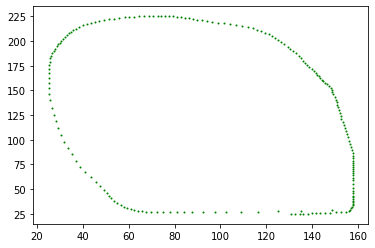

In [30]:
plt.scatter(data[:,0], data[:,1], label="template", s=1, c='g')
plt.show()

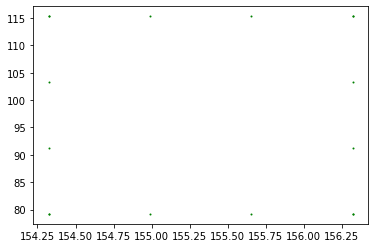

In [26]:
reload(rd)
# test_rect = rd.generate_rectangles(x1=50,y1=50,x2=107,y2=115)
test_rect = rd.square_from_line(data)
# test_rect = rd.bspline(test_rect, n=200, degree=3)
plt.scatter(test_rect[:,0], test_rect[:,1], label="template", s=1, c='g')
plt.show()

In [20]:
min_template_name, min_template_mse = None, np.inf
min_M = None
for template_name, template_func in rd.TEMPLATE_DICT.items():
    template = template_func(n)
    try:
        M, result = rd.get_transform(template, test_rect, projective=False)
        mse = rd.mean_squared_error(result, test_rect)
        if mse < min_template_mse:
            min_template_name = template_name
            min_template_mse = mse
            min_M = M
    except:
        continue
        print("Fail: ", template_name, " at: ", idx, stroke_index)

In [21]:
min_template_name

'square'

In [22]:
min_M

array([[  0.0069,   0.0008, 154.6051],
       [  0.0078,  -0.1382, 114.6933],
       [  0.    ,   0.    ,   1.    ]])

12.321117637265152


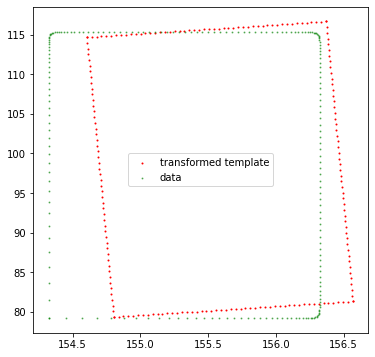

In [24]:
template_func = rd.TEMPLATE_DICT[min_template_name]
projectiveM = min_M
template = template_func(n)

# src_pts = template.astype(np.float32).reshape(-1,1,2)
# result = cv2.perspectiveTransform(src_pts, projectiveM.reshape(3,3)).reshape(-1,2)

result = cv2.transform(np.array([template], copy=True).astype(np.float32), projectiveM)[0][:,:-1]

mse = mean_squared_error(result, test_rect)
print(mse)

datacolors = rd.get_sequence_colors(n, plt.cm.Greens)
templatecolors = rd.get_sequence_colors(n, plt.cm.Reds)

plt.figure(figsize=(6, 6))
plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
plt.scatter(test_rect[:,0], test_rect[:,1], label="data", alpha=0.5, s=1, c='g')
plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

plt.show()

In [50]:
xs = np.linspace(0, l, n1)
ys = np.ones(n1) * 1

ys = np.linspace(0, l, n1)
xs = np.ones(n1) * 1

a = np.hstack([xs.reshape(-1,1), ys.reshape(-1,1)])
print(a.shape)

(200, 2)


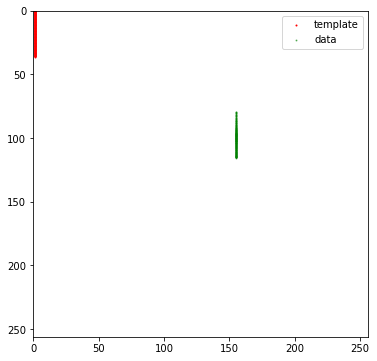

In [51]:
plt.figure(figsize=(6, 6))
plt.scatter(a[:,0], a[:,1], label="template", s=1, c='r')
plt.scatter(b[:,0], b[:,1], label="data", alpha=0.5, s=1, c='g')
plt.legend()
plt.xlim(0,w)
plt.ylim(h,0)

plt.show()

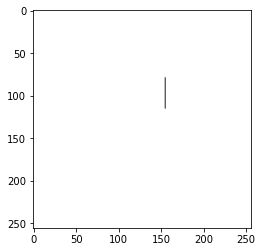

In [52]:
data = strokes_spline_fitted[1]
_ = rd.render_img(
    [data], 
    show=True,
    side=256,
    line_diameter=1,
    original_side = 256.,
)

In [59]:
p = [0,0,0.05]
T  = np.array([[np.cos(p[2]),-np.sin(p[2]),p[0]],[np.sin(p[2]), np.cos(p[2]),p[1]]])
Tr = np.matrix(np.vstack((T,[0,0,1]))).A
print(Tr)

[[ 0.9988 -0.05    0.    ]
 [ 0.05    0.9988  0.    ]
 [ 0.      0.      1.    ]]


In [60]:
result = cv2.transform(np.array([data], copy=True).astype(np.float32), Tr)[0][:,:-1]

In [62]:
mse = mean_squared_error(result, b)
print(mse)

42.83999406936995


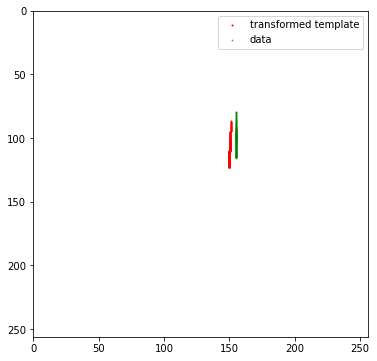

In [63]:
plt.figure(figsize=(6, 6))
plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
plt.scatter(b[:,0], b[:,1], label="data", alpha=0.5, s=1, c='g')
plt.legend()
plt.xlim(0,w)
plt.ylim(h,0)

plt.show()

{(13, 0): 'circle', (13, 1): 'arc', (13, 2): 'arc', (13, 3): 'arc'}


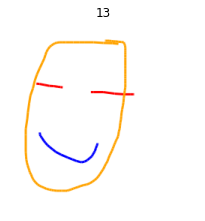

In [31]:
idx = 13
print(dict(filter(lambda x: x[0][0] == idx, M_name.items())))

rd.show_these_sketches(
    CONST.face_json,
    [idx], 
    [str(idx)], 
    [[]], 
    num_pngs_per_row = 6,
    row_figsize = 4,
    column_figsize = 4,
)

strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
    drawing_arr[idx], 
    b_spline_num_sampled_points=200,
)

array([0., 0.])

In [15]:
reload(rd)
#rd.get_transform_smallest_mse(strokes_spline_fitted[3])

<module 'read_datasets' from '/home/xiaoyuz1/amazon_turk/read_datasets.py'>

In [26]:
stroke_idx = 3
data = strokes_spline_fitted[stroke_idx]
print(M_name[(idx, stroke_idx)])

template_func = rd.TEMPLATE_DICT[M_name[(idx, stroke_idx)]]

circle


In [27]:
projectiveM = M_arr[(idx, stroke_idx)]
template = template_func(n)

In [ ]:
template_func = rd.TEMPLATE_DICT['circle']
template = template_func(n)
M, result = rd.get_transform(template, data, projective=False)

49.424936881037745


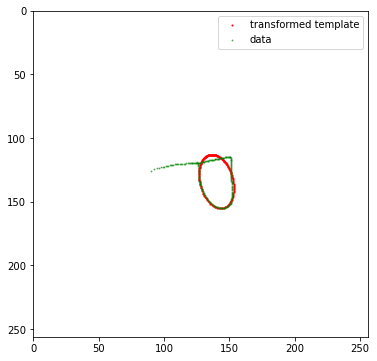

In [28]:
src_pts = template.astype(np.float32).reshape(-1,1,2)
result = cv.perspectiveTransform(src_pts, projectiveM.reshape(3,3)).reshape(-1,2)

mse = mean_squared_error(result, data)
print(mse)

datacolors = rd.get_sequence_colors(n, plt.cm.Greens)
templatecolors = rd.get_sequence_colors(n, plt.cm.Reds)

plt.figure(figsize=(6, 6))
plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')
plt.legend()
plt.xlim(0,w)
plt.ylim(h,0)

plt.show()

In [26]:
M

array([[ -0.2935,  -0.2548, 118.2643],
       [ -0.2234,  -0.8156, 195.5184],
       [  0.0003,  -0.0043,   1.    ]])

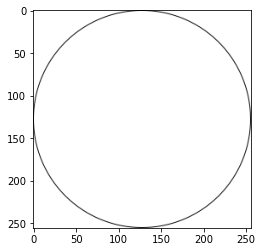

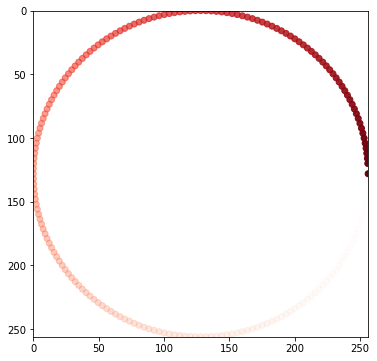

In [26]:

# template = rd.generate_arc(n1=200)
template = rd.generate_circle(n1=200, radius=100, x0=100, y0=100, template_size=256)
# template = rd.generate_square(n1 = 200, template_size=256)
# plt.scatter(template[:,0], template[:,1])
# plt.show()

_ = rd.render_img(
    [template], 
    show=True,
    side=256,
    line_diameter=1,
    original_side = 256.,
)

# template[:,0] = template[:,0][::-1]
# template[:,1] = template[:,1][::-1]


plt.figure(figsize=(6,6))
colors = rd.get_sequence_colors(len(template))
plt.scatter(template[:,0], template[:,1], c = colors)
 
plt.xlim(0,256)
plt.ylim(256,0)
plt.show()

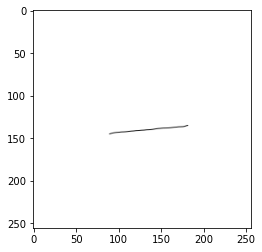

In [23]:
data = strokes_spline_fitted[6]
_ = rd.render_img(
    [data], 
    show=True,
    side=256,
    line_diameter=1,
    original_side = 256.,
)

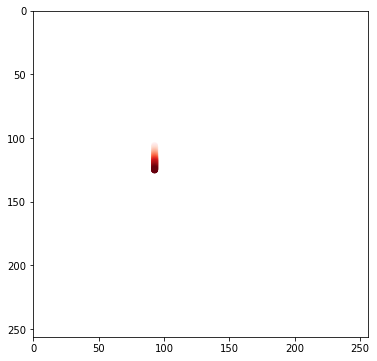

In [41]:
plt.figure(figsize=(6,6))
n = len(data)
px = np.linspace(0,10,n)
py = np.random.randn(n)
pz = np.linspace(0,1,n) 
colors = plt.cm.Reds(np.linspace(0,1,n))
colors[:,-1] = pz 
plt.scatter(data[:,0], data[:,1], c = colors)
 
plt.xlim(0,256)
plt.ylim(256,0)
plt.show()

In [3]:
import cv2
import numpy as np
import sys
from numpy.random import *

In [4]:
def del_miss(indeces, dist, max_dist, th_rate = 0.8):
    th_dist = max_dist * th_rate
    return np.array([indeces[0][np.where(dist.T[0] < th_dist)]])


In [5]:
def is_converge(Tr, scale):
    delta_angle = 0.0001
    delta_scale = scale * 0.0001
    
    min_cos = 1 - delta_angle
    max_cos = 1 + delta_angle
    min_sin = -delta_angle
    max_sin = delta_angle
    min_move = -delta_scale
    max_move = delta_scale
    
    return min_cos < Tr[0, 0] and Tr[0, 0] < max_cos and \
           min_cos < Tr[1, 1] and Tr[1, 1] < max_cos and \
           min_sin < -Tr[1, 0] and -Tr[1, 0] < max_sin and \
           min_sin < Tr[0, 1] and Tr[0, 1] < max_sin and \
           min_move < Tr[0, 2] and Tr[0, 2] < max_move and \
           min_move < Tr[1, 2] and Tr[1, 2] < max_move

In [6]:
def icp(d1, d2, max_iterate = 100):
    src = np.array([d1.T], copy=True).astype(np.float32)
    dst = np.array([d2.T], copy=True).astype(np.float32)
    
    knn = cv2.KNearest()
    responses = np.array(range(len(d2[0]))).astype(np.float32)
    knn.train(src[0], responses)
        
    Tr = np.array([[np.cos(0), -np.sin(0), 0],
                   [np.sin(0), np.cos(0),  0],
                   [0,         0,          1]])

    dst = cv2.transform(dst, Tr[0:2])
    max_dist = sys.maxint
    
    scale_x = np.max(d1[0]) - np.min(d1[0])
    scale_y = np.max(d1[1]) - np.min(d1[1])
    scale = max(scale_x, scale_y)
       
    for i in range(max_iterate):
        ret, results, neighbours, dist = knn.find_nearest(dst[0], 1)
        
        indeces = results.astype(np.int32).T     
        indeces = del_miss(indeces, dist, max_dist)  
        
        T = cv2.estimateRigidTransform(dst[0, indeces], src[0, indeces], True)

        max_dist = np.max(dist)
        dst = cv2.transform(dst, T)
        Tr = np.dot(np.vstack((T,[0,0,1])), Tr)
        
        if (is_converge(T, scale)):
            break
        
    return Tr[0:2]

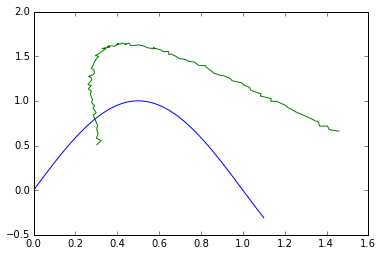

In [15]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    point_count = 100
    th = np.pi / 8
    move = np.array([[0.30], [0.5]])
    rnd_scale = 0.03
    x1 = np.linspace(0, 1.1, point_count)
    y1 = np.sin(x1 * np.pi)
    d1 = np.array([x1, y1])

    rot = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    rand = np.random.rand(2, point_count)*rnd_scale
    d2 = np.dot(rot, d1) + move
    d2 = np.add(d2, rand)

    plt.plot(d1[0], d1[1])
    plt.plot(d2[0], d2[1])
    plt.show()

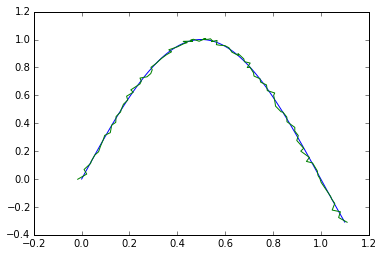

1.00166826979
22.6572180189
22.7913494968
[[ 0.92282598  0.3873764  -0.49228818]
 [-0.38870246  0.92493277 -0.35375819]]


In [16]:
    ret = icp(d1, d2)
    
    plt.plot(d1[0], d1[1])
    dst = np.array([d2.T], copy=True).astype(np.float32)
    dst = cv2.transform(dst, ret)
    plt.plot(dst[0].T[0], dst[0].T[1])
    plt.show()
    
    print ret[0][0] * ret[0][0] + ret[0][1] * ret[0][1]
    print np.arccos(ret[0][0]) / 2 / np.pi * 360
    print np.arcsin(ret[0][1]) / 2 / np.pi * 360

    print ret

In [ ]:
def icp(a, b,
        max_time = 1
    ):
    import cv2
    import numpy
    import copy
    import pylab
    import time
    import sys
    import sklearn.neighbors
    import scipy.optimize



    def res(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        r = numpy.sum(numpy.square(d[:,0])+numpy.square(d[:,1]))
        return r

    def jac(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],
                            [ numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        g = numpy.array([  numpy.sum(2*d[:,0]),
                        numpy.sum(2*d[:,1]),
                        numpy.sum(2*(d[:,0]*dUdth[:,0]+d[:,1]*dUdth[:,1])) ])
        return g
    
    def hess(p,src,dst):
        n = numpy.size(src,0)
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],[numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        H = numpy.zeros([3,3])
        H[0,0] = n*2
        H[0,2] = numpy.sum(2*dUdth[:,0])
        H[1,1] = n*2
        H[1,2] = numpy.sum(2*dUdth[:,1])
        H[2,0] = H[0,2]
        H[2,1] = H[1,2]
        d2Ud2th_R = numpy.matrix([[-numpy.cos(p[2]), numpy.sin(p[2])],[-numpy.sin(p[2]),-numpy.cos(p[2])]])
        d2Ud2th = (src*d2Ud2th_R.T).A
        H[2,2] = numpy.sum(2*(numpy.square(dUdth[:,0])+numpy.square(dUdth[:,1]) + d[:,0]*d2Ud2th[:,0]+d[:,0]*d2Ud2th[:,0]))
        return H
    
    
    t0 = time.time()
    init_pose = (0,0,0)
    src = numpy.array([a.T], copy=True).astype(numpy.float32)
    dst = numpy.array([b.T], copy=True).astype(numpy.float32)
    Tr = numpy.array([[numpy.cos(init_pose[2]),-numpy.sin(init_pose[2]),init_pose[0]],
                   [numpy.sin(init_pose[2]), numpy.cos(init_pose[2]),init_pose[1]],
                   [0,                    0,                   1          ]])
    print("src",numpy.shape(src))
    print("Tr[0:2]",numpy.shape(Tr[0:2]))
    src = cv2.transform(src, Tr[0:2])
    p_opt = numpy.array(init_pose)
    T_opt = numpy.array([])
    error_max = sys.maxsize
    first = False
    while not(first and time.time() - t0 > max_time):
        distances, indices = sklearn.neighbors.NearestNeighbors(n_neighbors=1, algorithm='auto',p = 3).fit(dst[0]).kneighbors(src[0])
        p = scipy.optimize.minimize(res,[0,0,0],args=(src[0],dst[0, indices.T][0]),method='Newton-CG',jac=jac,hess=hess).x
        T  = numpy.array([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],[numpy.sin(p[2]), numpy.cos(p[2]),p[1]]])
        p_opt[:2]  = (p_opt[:2]*numpy.matrix(T[:2,:2]).T).A       
        p_opt[0] += p[0]
        p_opt[1] += p[1]
        p_opt[2] += p[2]
        src = cv2.transform(src, T)
        Tr = (numpy.matrix(numpy.vstack((T,[0,0,1])))*numpy.matrix(Tr)).A
        error = res([0,0,0],src[0],dst[0, indices.T][0])

        if error < error_max:
            error_max = error
            first = True
            T_opt = Tr

    p_opt[2] = p_opt[2] % (2*numpy.pi)
    return T_opt, error_max


def main():
    import cv2
    import numpy
    import random
    import matplotlib.pyplot
    n1 = 100
    n2 = 75
    bruit = 1/10
    center = [random.random()*(2-1)*3,random.random()*(2-1)*3]
    radius = random.random()
    deformation = 2

    template = numpy.array([
        [numpy.cos(i*2*numpy.pi/n1)*radius*deformation for i in range(n1)], 
        [numpy.sin(i*2*numpy.pi/n1)*radius for i in range(n1)]
    ])

    data = numpy.array([
        [numpy.cos(i*2*numpy.pi/n2)*radius*(1+random.random()*bruit)+center[0] for i in range(n2)], 
        [numpy.sin(i*2*numpy.pi/n2)*radius*deformation*(1+random.random()*bruit)+center[1] for i in range(n2)]
    ])

    T,error = icp(data,template)
    dx = T[0,2]
    dy = T[1,2]
    rotation = numpy.arcsin(T[0,1]) * 360 / 2 / numpy.pi

    print("T",T)
    print("error",error)
    print("rotation°",rotation)
    print("dx",dx)
    print("dy",dy)

    result = cv2.transform(numpy.array([data.T], copy=True).astype(numpy.float32), T).T
    matplotlib.pyplot.plot(template[0], template[1], label="template")
    matplotlib.pyplot.plot(data[0], data[1], label="data")
    matplotlib.pyplot.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
    matplotlib.pyplot.legend(loc="upper left")
    matplotlib.pyplot.axis('square')
    matplotlib.pyplot.show()

if __name__ == "__main__":
    main()